# Downsampling
## Idea:
* Two dataset variants have different sizes, need same size to compare other dataset properties
* -> sample down the larger one, i.e. draw a random sample
## Question:
* Does the downsampling method affect attribute value frequencies?

In [1]:
from dataset_properties import split_by_source_id
from dataset_modifier import random_sample, random_sample_wrapper
import numpy as np
import scipy.stats as stats

In [2]:
import pandas as pd
# get the data
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,AM28693,1fdc308dcc35344c6d5c20845fad641d,SUE,BARNES,SHUFFLER,1946,,BURKE,VALDESE,28690,LAKEVIEW ACRES,F,NL,W
1,A,CZ67291,b36b8c16c743ed415c6a7f3fc1a3b859,RONALD,EUGENE,LATTIMER,1953,OH,MOORE,PINEHURST,28374,BURNING TREE,M,NL,W
2,A,BN204837,401b7f6f5e107dbb009da197a2b05d9e,DEIDRE,MARLANA,MARTIN,1973,NC,FORSYTH,WINSTON SALEM,27105,CARVER GLEN,F,NL,B
3,A,EH737737,85f059d91b803b5835a8b9762a3170cb,KURT,,BALEN,1968,PA,WAKE,APEX,27502,ASHLEY DOWNS,M,NL,W
4,A,DT41462,f70a42ce915731cabafc5daa1bfbceeb,WORTH,BROWN,FOUTZ,1919,,ROWAN,SALISBURY,28146,MORRISON,M,NL,W


### Idea:
* Describe attr. value frequency-distribution by its skewness
#### Skewness of FIRSTNAME

In [8]:
df.FIRSTNAME.value_counts().skew()

22.40701130969864

In [14]:
df_a, df_b = split_by_source_id(df)
df_res = random_sample(df_a, df_b, 100_000)
df_res.FIRSTNAME.value_counts().skew()

17.985487665414905

In [12]:
df_res = random_sample(df_a, df_b, 50_000)
df_res.FIRSTNAME.value_counts().skew()

14.078208892313993

In [13]:
df_res = random_sample(df_a, df_b, 10_000)
df_res.FIRSTNAME.value_counts().skew()

8.820920270502942

### Skewness influenced by sample size

In [15]:
# same with regular random sample:
df.sample(50_000).FIRSTNAME.value_counts().skew()

14.189379823199365

#### Plot it

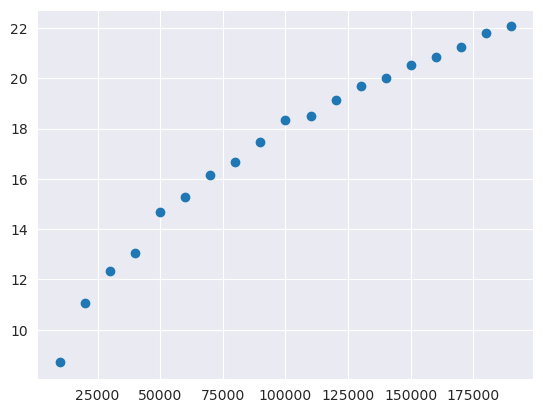

In [21]:
import matplotlib.pyplot as plt

sizes = list(range(10_000, 200_000, 10_000))  # [10k, 20k, ..., 190k]
plt.scatter(
    x=sizes,
    y=[random_sample(df_a, df_b, s).FIRSTNAME.value_counts().skew() for s in sizes]
)

### Compare two frequency distributions
https://stats.stackexchange.com/questions/289021/statistical-test-for-comparing-two-frequency-distributions-expressed-as-arrays

### Observation:
* Skewness influenced by random down-sampling
### Question: TODO
* Should skew be preserved when sampling down?
* If so, how to?

### Approach 1 (under the incorrect assumption that skewness is amplified by dataset size. Actually, it is influenced by random down-sampling)
Method Parameters:
* df1, df2 -> the two datasets whose skewnesses should be compared, i.e. the original dataset and the down-sampled version.
* sample_size -> the size of the random samples that should be drawn per iteration

In [15]:
from scipy.stats import ttest_ind

def compare_skews(df1, df2, attr_name, sample_size, iterations):
    skews1 = []
    skews2 = []
    for i in range(iterations):
        # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
        skew1, skew2 = [df[attr_name].sample(sample_size,
                                             random_state=i).value_counts().skew()
                        for df in (df1, df2)]
        skews1.append(skew1)
        skews2.append(skew2)
    return ttest_ind(skews1, skews2).pvalue

In [16]:
# split dataset into two sources a and b
df_a, df_b = split_by_source_id(df)

In [31]:
downsampling_size = 50_000
sample_size = 10_000
iterations = 1000
seed = 42
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

0.41637549799938256

In [32]:
seed = 43
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

3.216433591828427e-19

### Nur durch Veränderung des Seeds komplett anderes Ergebnis
* Erwartung war eigentlich, mit den vielen Iterationen den Zufallsfaktor auszugleichen
* D.h. vllt stimmt etwas mit der compare_skews Methode nicht.
* Vielleicht ist aber auch die Sample Größe (50k) einfach zu klein, sodass schon mal durch Zufall eine etwas andere Attributwert-Verteilung heraus kommen kann? Dann bräuchte ich zum Testen einen größeren Datensatz (ca 1M)

In [45]:
# a closer look at the skew lists
df1 = df
df2 = df_res
skews1 = []
skews2 = []
for i in range(iterations):
    # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
    skew1, skew2 = [df.FIRSTNAME.sample(sample_size,
                                         random_state=i).value_counts().skew()
                    for df in (df1, df2)]
    skews1.append(skew1)
    skews2.append(skew2)

In [47]:
from scipy.stats import describe

In [48]:
describe(skews1)

DescribeResult(nobs=1000, minmax=(7.944169414740913, 9.967781291470358), mean=8.858960652745031, variance=0.10468497978797489, skewness=0.21115252662227504, kurtosis=0.00017616731422309684)

In [49]:
describe(skews2)

DescribeResult(nobs=1000, minmax=(7.840514802745674, 9.707595824569646), mean=8.73600791756071, variance=0.0797711299276887, skewness=0.07855222258322854, kurtosis=0.09130214238790346)

In [51]:
import seaborn as sns

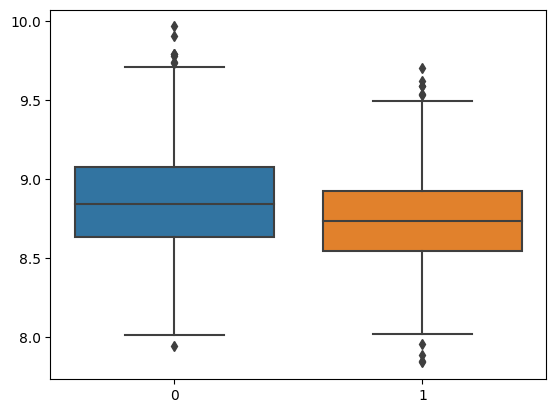

In [56]:
sns.boxplot(data=[skews1, skews2])
plt.show()

In [74]:
from tqdm import tqdm

def compare_skews2(df, downsampling_size, attr_name, sample_size, iterations, seed_incr=0):
    df_a, df_b = split_by_source_id(df)
    skews1 = []
    skews2 = []
    for i in tqdm(range(iterations)):
        df_res = random_sample(df_a, df_b, downsampling_size, seed=i+seed_incr)
        skew1, skew2 = [
            _df.sample(sample_size, random_state=i)[attr_name].value_counts().skew()
            for _df in (df, df_res)
        ]
        skews1.append(skew1)
        skews2.append(skew2)
    return (skews1, skews2)

In [66]:
downsampling_size = 5000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]


0.05193975536287609

In [68]:
downsampling_size = 5000
sample_size = 1000
iterations = 100
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


0.5271192065009521

In [69]:
downsampling_size = 10_000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]


0.06070039904807875

In [70]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [10:05<00:00,  1.65it/s]


0.8450119407899201

In [72]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=1)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:42<00:00,  1.92it/s]


0.544166396644953

In [75]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=2)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:59<00:00,  1.86it/s]


0.9149762755309175

In [76]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=3)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s]


0.5269670447139234

## New Approach:
Compare the Frequency Distributions of both datasets
* Correlation Coefficient
* Rank Correlation Coefficient
* chi² test https://stats.stackexchange.com/questions/289021/statistical-test-for-comparing-two-frequency-distributions-expressed-as-arrays
* KL-Divergence
* Anderson-Darling test

#### Chi-Square GOF test

In [110]:
df_res = random_sample_wrapper(df, 50_000, seed=42)

In [111]:
def ComputeChiSquareGOF(expected, observed):
    """
    Runs a chi-square goodness-of-fit test and returns the p-value.
    Inputs:
    - expected: numpy array of expected values.
    - observed: numpy array of observed values.
    Returns: p-value
    """
    expected_scaled = expected / float(sum(expected)) * sum(observed)
    result = stats.chisquare(f_obs=observed, f_exp=expected_scaled)
    return result[1]

def MakeDecision(p_value):
    """
    Makes a goodness-of-fit decision on an input p-value.
    Input: p_value: the p-value from a goodness-of-fit test.
    Returns: "different" if the p-value is below 0.05, "same" otherwise
    """
    return "different" if p_value < 0.05 else "same"

In [112]:
e = df.FIRSTNAME.value_counts().sort_values(ascending=False)
o = df_res.FIRSTNAME.value_counts().sort_values(ascending=False)

In [113]:
# filter the categories that are not in both datasets
e = e[e.index.isin(o.index)]
e.shape == o.shape

True

In [114]:
# scale equally
e = e / float(sum(e)) * sum(o)

In [115]:
(e.index == o.index).all()

False

In [116]:
p = ComputeChiSquareGOF(e, o)
p

0.9628106671762247

In [117]:
MakeDecision(p)

'same'

In [118]:
import matplotlib.pyplot as plt

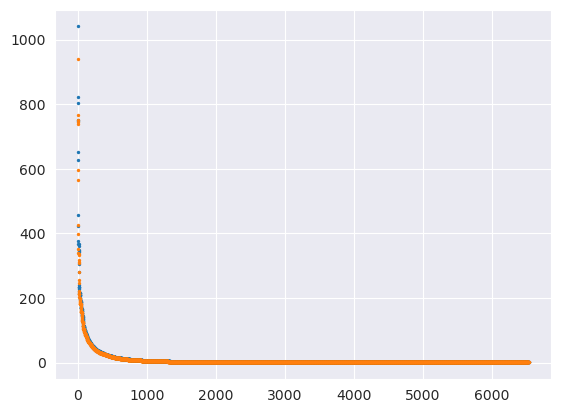

In [119]:
for s in [e, o]:
    plt.scatter(x=range(s.shape[0]), y=s.tolist(), s=2)

#### Observation:
* Chi test says data is similar
* Data looks the same
* But index positions of categories are different

What happens if index positions are same?

In [124]:
# sort by indices
e = e.sort_index()
o = o.sort_index()
(e.index == o.index).all()

True

In [125]:
p = ComputeChiSquareGOF(e, o)
p

1.2168179646286044e-116

In [126]:
MakeDecision(p)

'different'

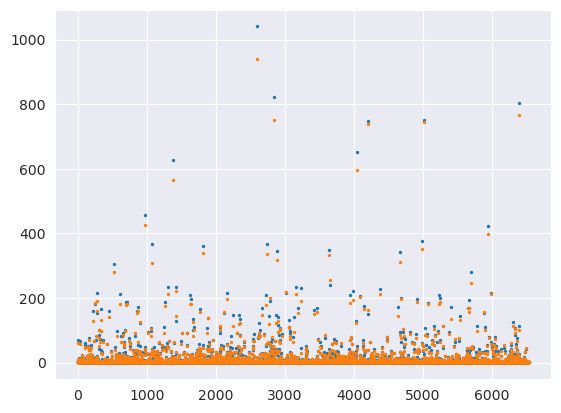

In [127]:
for s in [e, o]:
    plt.scatter(x=range(s.shape[0]), y=s.tolist(), s=2)

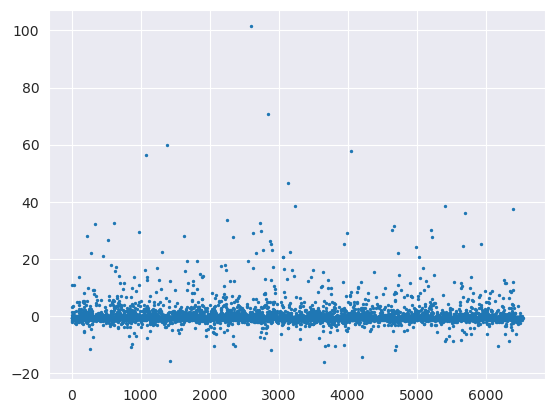

In [128]:
diff = e - o
plt.scatter(x=range(diff.shape[0]), y=diff.tolist(), s=2)

#### Kullback-Leibler divergence
The Kullback-Leibler (KL) divergence is a measure of the difference between two probability distributions. It calculates the amount of information lost when approximating one distribution with another. A lower KL divergence value between two distributions indicates that they are more similar, while a higher value indicates that they are more dissimilar.

In [24]:
from scipy.stats import entropy
# from the documentation:
# If qk is not None, then compute the relative entropy D = sum(pk * log(pk / qk)). This quantity is also known as the Kullback-Leibler divergence.
# This routine will normalize pk and qk if they don’t sum to 1.

In [132]:
e = df.FIRSTNAME.value_counts().sort_values(ascending=False)
o = df_res.FIRSTNAME.value_counts().sort_values(ascending=False)

In [133]:
# filter the categories that are not in both datasets
e = e[e.index.isin(o.index)]
e.shape == o.shape

True

In [134]:
D = entropy(e, o, 2)
D

0.04056156190637871

In [135]:
# scale equally
e = e / float(sum(e)) * sum(o)

In [136]:
D = entropy(e, o, 2)
D

0.04056156190637897

0.04 is small, suggests that the distributions are similar
But here, again, order of the categories is not the same.
It's important to note that KL divergence is sensitive to the order of the categories, and when the categories are not in the same order, the result will be different.

In [137]:
# sort by indices
e = e.sort_index()
o = o.sort_index()
(e.index == o.index).all()

True

In [138]:
D = entropy(e, o, 2)
D

0.0741650248812191

If the order of categories is important for your research question, then the result of 0.0741650248812191 indicates that the two frequency distributions are not as similar as before.

#### Rank Correlation Coefficient
A rank-correlation coefficient, such as the Spearman's rank correlation coefficient, can be used to measure the similarity between two frequency distributions. It measures the correlation between the rank order of the values in two datasets. A rank correlation coefficient of 1 indicates that there is a perfect positive correlation between the ranks of the two datasets, which means that the two frequency distributions are identical. A rank correlation coefficient of -1 indicates that there is a perfect negative correlation between the ranks, which means that the two frequency distributions are completely dissimilar.

The Spearman's rank correlation coefficient is a non-parametric measure and it doesn't assume that the data is normally distributed, which is a good property when the distribution is not normal.

It is a good alternative measure to compare frequency distribution, especially if the order of the categories is important. It is a more robust measure to outliers and it can handle ties in the data.

It's important to note that the rank correlation coefficient only considers the rank order of the values in the two datasets and not the actual values themselves, which may not capture all the information about the similarity between the two frequency distributions.

In [148]:
from scipy.stats import spearmanr

In [149]:
e = df.FIRSTNAME.value_counts().sort_values(ascending=False)
o = df_res.FIRSTNAME.value_counts().sort_values(ascending=False)

In [150]:
# filter the categories that are not in both datasets
e = e[e.index.isin(o.index)]
e.shape == o.shape

True

In [155]:
res = spearmanr(e, o)
res

SignificanceResult(statistic=0.9139760271834815, pvalue=0.0)

#### Interpretation:
* pvalue = The p-value for a hypothesis test whose null hypothesis is that two sets of data are linearly uncorrelated. See alternative above for alternative hypotheses. pvalue has the same shape as statistic.
* -> strong positive correlation
* Again, the index positions are not the same

In [156]:
# sort by indices
e = e.sort_index()
o = o.sort_index()
(e.index == o.index).all()

True

In [157]:
res = spearmanr(e, o)
res

SignificanceResult(statistic=0.8316364766083224, pvalue=0.0)

Even with same index oder, there is still a strong positive correlation